In [22]:
%reset -f
%matplotlib qt
import sys
import mne
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

#%load_ext autoreload
#%autoreload 2
%run EEG_auxiliary_module.ipynb
%run general_tools.ipynb
mne.__version__
mne.set_log_level("WARNING")

infolder, outfolder = find_folder()

conf = dict()

# EEG parameters
resample = 200

## Imagery

### Loading and preprocessing data

In [6]:
%run EEG_auxiliary_module.ipynb
# Defining triggers
trigs=list(range(31, 36))
event_ids={str(x):x for x in trigs}


# Loading first S02 session
file_name='IR_05_S01.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_a = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,5), resample = resample, filt=(0.1,40))


# Loading second S02 session
file_name='IR_05_S02.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_b = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,5), resample = resample, filt=(0.1,40))



epochs_im = mne.concatenate_epochs([epochs_a,epochs_b])

%reset_selective -f 4_ 

#dropping status channel
epochs_im.drop_channels('Status')

# equalizing number of cases between conditions
epochs_im.equalize_event_counts(event_ids=event_ids, method='mintime') 

# zscoring, thresholding, rereferencing
epochs_im = zscore_threshold_epochs(epochs_im, 2, 3) 
epochs_im.set_eeg_reference("average")

fname = op.join(outfolder,'S05_imag.fif')
print('Starting saving')
epochs_im.save(fname)

# averaging by block
epochs_im = block_average(epochs_im, 4, 24, kind = 'imagery')

#print('Starting saving')
fname = op.join(outfolder,'S05_imag_aver.fif')
epochs_im.save(fname)
os.system('say "your program has finished"')
epochs_im

(480, 64, 1020)
Starting saving
Overwriting existing file.
Starting averaging
No zscoring performed
Overwriting existing file.


<EpochsArray  |   120 events (all good), -0.1 - 4.995 sec, baseline [None, 0], ~59.9 MB, data loaded, with metadata,
 '31': 24
 '32': 24
 '33': 24
 '34': 24
 '35': 24>

### Running discrimination analysis

In [7]:
import pandas as pd
%run EEG_auxiliary_module.ipynb
im_names = ['mcy','sgo','sjo','est','tsw']
times=[(1,2)]
times=[(0,5),(0,4),(0,3),(0,2),(0,1),(1,2),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5),(3,4),(3,5),(4,5)]
results=[]# Loading first S02 session
durs=[];
for i in times:
    X, Y = convert_epochs_to_2D_array(epochs_im, times=i)
    confusion, duration = run_eeg_svm(X,Y,12)
    results.append(confusion)
    durs.append(duration)

os.system('say "your program has finished"')

Progress: [####################] 100.0%
The overall accuracy is 51.5 and the duration is 0.1 minutes


0

### Presenting results

In [8]:
from scipy.spatial.distance import pdist, squareform
for i in results:
    print(f'Accuracy of the entire set is {np.mean(squareform(i))*100:.2f}%')
confusion_df = pd.DataFrame(results[5], columns = im_names, index = im_names)
fname = op.join(outfolder,'conf_IR_05_imag.csv')
confusion_df.to_csv(fname,index = True, header = True)
confusion_df.head()

Accuracy of the entire set is 47.92%
Accuracy of the entire set is 45.42%
Accuracy of the entire set is 45.83%
Accuracy of the entire set is 51.46%
Accuracy of the entire set is 48.96%
Accuracy of the entire set is 52.08%
Accuracy of the entire set is 47.08%
Accuracy of the entire set is 47.08%
Accuracy of the entire set is 50.42%
Accuracy of the entire set is 45.42%
Accuracy of the entire set is 45.83%
Accuracy of the entire set is 48.33%
Accuracy of the entire set is 49.38%
Accuracy of the entire set is 49.58%
Accuracy of the entire set is 51.46%


,mcy,sgo,sjo,est,tsw
mcy,0.000000,0.520833,0.500000,0.500000,0.604167
sgo,0.520833,0.000000,0.479167,0.500000,0.375000
sjo,0.500000,0.479167,0.000000,0.604167,0.541667
est,0.500000,0.500000,0.604167,0.000000,0.583333
tsw,0.604167,0.375000,0.541667,0.583333,0.000000


## Perception

### Loading and preprocessing data

In [24]:
%run EEG_auxiliary_module.ipynb
# Defining triggers
trigs=list(range(101, 151))+list(range(201, 251))
event_ids={str(x):x for x in trigs}

# Loading first S02 session
file_name='IR_05_S01.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_a = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,1), resample = resample, filt=(0.1,100))
epochs_a = epochs_a[100:]

# Loading second S02 session
file_name='IR_05_S02.bdf'
fname = op.join(infolder,file_name)

# Load data
epochs_b = preprocessing_eeg(fname, event_ids, segment_times=(-0.1,1), resample = resample, filt=(0.1,100))
epochs_b = epochs_b[100:]


# creating one data
epochs_perc = mne.concatenate_epochs([epochs_a,epochs_b])
%reset_selective -f 4_ 

#dropping status channel
#epochs_04.drop(np.where(epochs_04.events[:,2]==230)[0][-2:])
epochs_perc.drop_channels('Status')

# equalizing number of cases between conditions
epochs_perc.equalize_event_counts(event_ids=event_ids, method='mintime') 

# adding metadata
epochs_perc.metadata = create_meta_events_perception(epochs_perc.events[:,2]) 

# zscoring, thresholding, rereferencing
epochs_perc = zscore_threshold_epochs(epochs_perc, dims=2, threshold=3) 
epochs_perc.set_eeg_reference("average")

print('Starting saving')
fname = op.join(outfolder,'S05_perc-epo.fif')
epochs_perc.save(fname)



os.system('say "your program has finished"')

(4800, 64, 220)
Starting saving
Overwriting existing file.


0

In [25]:
# averaging by block
%run EEG_auxiliary_module.ipynb
epochs_perc1 = block_average(epochs_perc, 4, 12, kind='perc')
#epochs_perc = block_average(epochs_perc, 48, 1, kind='perc')

#print('Starting saving')
fname = op.join(outfolder,'S00_perc_aver-epo.fif')
epochs_perc1.save(fname)

Starting averaging
No zscoring performed
Overwriting existing file.


In [27]:
epochs_0 = mne.read_epochs(fname)

In [32]:
len(epochs_0['101'])

12

In [19]:
epochs_perc.info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | True
    dev_head_t : Transform | 3 items
    dig : list | 67 items (3 Cardinal, 64 EEG)
    events : list | 0 items
    highpass : float | 0.1 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : tuple | 2019-08-06 12:24:27 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 200.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneTy

In [15]:
#fname = op.join(outfolder,'S05_perc-epo.fif')
print(fname)
epochs_0 = mne.read_epochs(fname)
epochs_0

//Users/dannem/Documents/Ilya_study/Analysis/S00_perc_aver-epo.fif


JSONDecodeError: Expecting ':' delimiter: line 1 column 6 (char 5)

### Running discrimination analysis

In [4]:
%run EEG_auxiliary_module.ipynb
times=[(0.05,0.65)]
results=[]
durs=[];
for i in times:
    X, Y = convert_epochs_to_2D_array(epochs_perc, times=i)
    #Y = np.array(convert_lbl(Y))
    confusion, duration = run_eeg_svm(X, Y, 12)
    results.append(confusion)
    durs.append(duration)
    print(i)
    #np.save('/Users/dannem/Documents/Ilya_study/Analysis/conf_IR_02_S01_c.csv',confusion)
os.system('say "your program has finished"')
#results

Progress: [####################] 100.0%
The overall accuracy is 63.8 and the duration is 9.9 minutes
(0.05, 0.65)


0

### Presenting results

In [5]:
confusion=results[0]
from scipy.spatial.distance import squareform
print(f'Accuracy of the upright stimuli is {np.mean(squareform(confusion[0:50,0:50]))*100:.4f}%')
print(f'Accuracy of the upright unfamiliary stimuli is {np.mean(squareform(confusion[0:25,0:25]))*100:.4f}%')
print(f'Accuracy of the upright famous stimuli is {np.mean(squareform(confusion[25:50,25:50]))*100:.4f}%')
print(f'Accuracy of the inverted stimuli is {np.mean(squareform(confusion[50:,50:]))*100:.4f}%')
print(f'Accuracy of the inverted unfamiliar stimuli is {np.mean(squareform(confusion[50:75,50:75]))*100:.4f}%')
print(f'Accuracy of the inverted famous stimuli is {np.mean(squareform(confusion[75:,75:]))*100:.4f}%')
print(f'Accuracy of the entire set is {np.mean(squareform(confusion))*100:.4f}%')

## Correlation results
corr=np.corrcoef(squareform(confusion[0:25,0:25]),squareform(confusion[50:75,50:75]))
print(f'Correlation between identity discrimination in upright and inverted famous faces is {corr[0,1]:.3f}')
corr=np.corrcoef(squareform(confusion[25:50,25:50]),squareform(confusion[75:100,75:100]))
print(f'Correlation between identity discrimination in upright and inverted unfamiliar faces is {corr[0,1]:.3f}')
conf['perc'] = results[0]
file_name='conf_mat_perc_05.csv'
fname = op.join(outfolder,file_name)
np.savetxt(fname, conf['perc'], delimiter=',')


Accuracy of the upright stimuli is 55.4490%
Accuracy of the upright unfamiliary stimuli is 57.3194%
Accuracy of the upright famous stimuli is 53.2917%
Accuracy of the inverted stimuli is 53.2789%
Accuracy of the inverted unfamiliar stimuli is 56.3333%
Accuracy of the inverted famous stimuli is 49.9444%
Accuracy of the entire set is 63.7778%
Correlation between identity discrimination in upright and inverted famous faces is 0.073
Correlation between identity discrimination in upright and inverted unfamiliar faces is 0.042


# Data reduction

In [ ]:
from sklearn.decomposition import PCA, FastICA

X = epochs_02.get_data()
pca = UnsupervisedSpatialFilter(PCA(30), average=False)
pca_data = pca.fit_transform(X)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(30, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA", time_unit='s')


In [ ]:
epochs_02.drop_bad()
epochs_02.plot_drop_log()

## Plotting

In [20]:
from mne.viz import plot_epochs_image
picks='PO8'
#epochs_02['120'].plot(block=True,picks=picks)
trigs=list(range(101,151))+list(range(201,251))
#trigs=list(range(31, 36))
trigs=[str(x) for x in trigs]
for i in trigs[:10]:
    plot_epochs_image(epochs[i], picks=picks, vmin=-100, vmax=750)


In [40]:
plot_epochs_image(epochs_02['35'], picks=picks, vmin=-100, vmax=750)

[<Figure size 640x480 with 4 Axes>]

In [ ]:
classes = set(Y)
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_xticks(range(len(classes)))
ax.axhline(50, color='k')
ax.axvline(50, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

# Tools

In [ ]:
who_ls

In [ ]:
import mne
import numpy as np
import os.path as op

# Loading first ND sessioin
file_name='IR_02_S03.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)
montage = mne.channels.read_montage("standard_1020")
raw = mne.io.read_raw_bdf(fname,montage=montage,
                              preload=True)
events = mne.find_events(raw, initial_event=True, 
                                 consecutive=True, shortest_event=1)
unique, counts = np.unique(events[:,2], return_counts=True)
print(list(zip(unique,counts)))

## Loading data

In [ ]:
# Loading first ND sessioin
file_name='IR_01_Pilot_a.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)

# Load events
events=np.genfromtxt('/Users/dannem/Documents/Ilya_study/Data/01_inv_recon_2019_May_13_1027_fixed_triggers.csv',delimiter=',')
events=events.astype('int32')

# Load data
epochs_01_a = preprocessing_eeg(fname, event_ids, events=events, segment_times=(-0.1,1.8))
X, Y = convert_epochs_to_2D_array(epochs_01_a, times=(0.05,0.65), dims=(1,2),threshold=3)
confusion, duration = run_eeg_svm(X,Y,5)

In [ ]:
# Loading third ND sessioin
file_name='triggers_test.bdf'
file_folder='/Users/dannem/Documents/Ilya_study/Data'
fname = op.join(file_folder,file_name)

# Load data
epochs_01_c = preprocessing_eeg(fname, event_ids, crop=(4020,None))
X, Y = convert_epochs_to_2D_array(epochs_01_c, times=(0.05,0.65), dims=(0,1),threshold=3)
confusion, duration = run_eeg_svm(X,Y,5)

# Correlation analysis

## Theoretical observer

In [55]:
import pandas as pd
from scipy.spatial.distance import squareform, pdist
%run EEG_auxiliary_module.ipynb
pr_names = ['adi','ani','ama','ago','aza','ekl','evu','epo','eiv','ech','ian','jpi','kda',
           'kgo','mbo','mbe','ofa','pan','pga','rga','siv','tar','tka','yst','ype','ase',
           'aha','ake','cmo','eol','epa','ecl','ero','est','ewa','jla','jal','kpe','kkn',
            'kst','mcy','ndo','npo','owi','pcr','rmc','rwi','sjo','sgo','tsw']
folder1 = '/Users/dannem/Documents/Ilya_study/builder_exp/set3/east'
folder2 = '/Users/dannem/Documents/Ilya_study/builder_exp/set3/west'
df = pd.concat((image_to_df(folder1),image_to_df(folder2)))
df['origin'] = ['east']*25+['west']*25
conf = squareform(pdist(df.iloc[:,:16428],'euclidean'))
df_to = pd.DataFrame(conf, columns = pr_names, index = pr_names)
df_to.head()

,adi,ani,ama,ago,aza,ekl,evu,epo,eiv,ech,...,mcy,ndo,npo,owi,pcr,rmc,rwi,sjo,sgo,tsw
adi,0.000000,4489.830620,4906.270580,5824.954420,5041.518918,4902.574630,6559.865852,5153.931412,4898.938661,4938.098521,...,6179.602333,5206.228481,5200.888962,4214.418465,5110.767261,5469.482517,5010.585994,5338.719697,3974.510033,5340.549691
ani,4489.830620,0.000000,3678.950937,4600.964573,4966.770983,3645.270498,5977.966962,4063.287093,3810.175980,4916.795501,...,5458.893294,4403.315569,4008.828632,4237.505634,5338.092262,4638.537269,3899.542409,4411.413719,4336.921604,5081.374617
ama,4906.270580,3678.950937,0.000000,4477.460776,4191.213667,3719.249790,5448.596608,3872.432311,3812.488033,4957.694222,...,5577.925062,3924.070591,3463.431680,4122.003154,5724.599986,4180.841542,3669.757621,4172.211764,4085.084944,4495.145826
ago,5824.954420,4600.964573,4477.460776,0.000000,4882.191823,4922.978773,4671.313092,4064.447195,5281.285071,4832.364742,...,5208.031970,4370.819717,4079.677193,4656.617549,6030.401313,5020.225991,4441.640463,5939.213921,5124.202572,5212.722225
aza,5041.518918,4966.770983,4191.213667,4882.191823,0.000000,4940.260418,6281.366810,4748.503554,5196.898594,4598.368624,...,5602.227771,4571.685466,5007.937999,4311.325086,5765.930541,5289.494872,4554.444313,5223.437278,4496.814984,5630.589667


In [215]:
type(data)

numpy.ndarray

In [75]:
# Comparing confusibility matrices
import pandas as pd
from scipy.spatial.distance import squareform
file_name='conf_mat.npy'
fname = op.join(file_folder,file_name)
conf = np.load(fname, allow_pickle =  True).item()
im_names = ['mcy','sgo','sjo','est','tsw']
corr_names = ['est','mcy','sjo','sgo','tsw']
pr_names = ['adi','ani','ama','ago','aza','ekl','evu','epo','eiv','ech','ian','jpi','kda',
           'kgo','mbo','mbe','ofa','pan','pga','rga','siv','tar','tka','yst','ype','ase',
           'aha','ake','cmo','eol','epa','ecl','ero','est','ewa','jla','jal','kpe','kkn',
            'kst','mcy','ndo','npo','owi','pcr','rmc','rwi','sjo','sgo','tsw']
df_imag = pd.DataFrame(conf['imag'][1],columns = im_names, index = im_names)
df_perc = pd.DataFrame(conf['perc'])
df_perc.columns = [pr_names*2]
df_perc.index = [pr_names*2]
idx = pd.IndexSlice
df_perc_imag = df_perc.loc[idx[im_names], idx[im_names]]
print(df_imag.head())
df_imag = df_imag.reindex(corr_names)
df_imag = df_imag.transpose().reindex(corr_names).transpose()
df_imag.head()
df_to_imag = df_to.loc[idx[im_names], idx[im_names]]
df_to_imag = df_to_imag.reindex(corr_names)
df_to_imag = df_to_imag.transpose().reindex(corr_names).transpose()
# compute correlations
up_corr = np.corrcoef(squareform(df_imag),squareform(df_perc_imag.iloc[:5,:5].values))
print(f'Correlation between upright percieved and imagary discrimination is {up_corr[1,0]:.2f}')
in_corr = np.corrcoef(squareform(df_imag),squareform(df_perc_imag.iloc[-5:,-5:].values))
print(f'Correlation between inverted percieved and imagary discriminations is {in_corr[1,0]:.2f}')

to_imag_corr = np.corrcoef(squareform(df_to_imag),squareform(df_imag.iloc[:5,:5].values))
print(f'Correlation between imagery and TO {to_imag_corr[1,0]:.2f}')


up_perc_to_corr = np.corrcoef(squareform(df_to.values),squareform(df_perc.iloc[:50,:50].values))
print(f'Correlation between upright percieved and TO discriminations is {up_perc_to_corr[1,0]:.2f}')
in_perc_to_corr = np.corrcoef(squareform(df_to.values),squareform(df_perc.iloc[50:100,50:100].values))
print(f'Correlation between inverted percieved and TO discriminations is {in_perc_to_corr[1,0]:.2f}')
up_perc_to_corr_unf = np.corrcoef(squareform(df_to.values[:25,:25]),squareform(df_perc.iloc[:25,:25].values))
print(f'Correlation between unfamiliar upright percieved and TO discriminations is {up_perc_to_corr_unf[1,0]:.2f}')
up_perc_to_corr_fam = np.corrcoef(squareform(df_to.values[25:50,25:50]),squareform(df_perc.iloc[25:50,25:50].values))
print(f'Correlation between famous upright percieved and TO discriminations is {up_perc_to_corr_fam[1,0]:.2f}')

in_perc_to_corr_unf = np.corrcoef(squareform(df_to.values[:25,:25]),squareform(df_perc.iloc[50:75,50:75].values))
print(f'Correlation between unfamiliar inverted percieved and TO discriminations is {in_perc_to_corr_unf[1,0]:.2f}')
in_perc_to_corr_fam = np.corrcoef(squareform(df_to.values[25:50,25:50]),squareform(df_perc.iloc[75:100,75:100].values))
print(f'Correlation between famous inverted percieved and TO discriminations is {in_perc_to_corr_fam[1,0]:.2f}')

          mcy       sgo       sjo       est       tsw
mcy  0.000000  0.541667  0.541667  0.645833  0.458333
sgo  0.541667  0.000000  0.625000  0.645833  0.708333
sjo  0.541667  0.625000  0.000000  0.583333  0.812500
est  0.645833  0.645833  0.583333  0.000000  0.541667
tsw  0.458333  0.708333  0.812500  0.541667  0.000000
Correlation between upright percieved and imagary discrimination is -0.34
Correlation between inverted percieved and imagary discriminations is 0.06
Correlation between imagery and TO -0.22
Correlation between upright percieved and TO discriminations is 0.05
Correlation between inverted percieved and TO discriminations is 0.14
Correlation between unfamiliar upright percieved and TO discriminations is 0.12
Correlation between famous upright percieved and TO discriminations is -0.01
Correlation between unfamiliar inverted percieved and TO discriminations is 0.18
Correlation between famous inverted percieved and TO discriminations is 0.07


In [65]:
df_to_imag

,est,mcy,sjo,sgo,tsw
est,0.000000,6328.464348,5693.663847,4520.609251,5391.608387
mcy,6328.464348,0.000000,6230.088844,5487.058502,5303.310287
sjo,5693.663847,6230.088844,0.000000,4853.069956,5463.593232
sgo,4520.609251,5487.058502,4853.069956,0.000000,4715.132766
tsw,5391.608387,5303.310287,5463.593232,4715.132766,0.000000


In [55]:
len(list(zip(pr_names*2, ['east']*25+['west']*25)))

50

In [61]:
np.tile(['east']*25+['west']*25,2)

array(['east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'east', 'east', 'east', 'east', 'east',
       'east', 'east', 'east', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west', 'west', 'west', 'west', 'west',
       'west', 'west', 'west', 'west'], dtype='<U4')

In [53]:
from scipy.spatial.distance import squareform, pdist
Y = squareform(pdist(df.iloc[:,:16428],'euclidean'))
Y.shape

(50, 50)

In [69]:
df_perc_imag.iloc[:5,:5].values

array([[0.        , 0.81818182, 0.77272727, 0.77272727, 0.45454545],
       [0.81818182, 0.        , 0.77272727, 0.63636364, 0.86363636],
       [0.77272727, 0.77272727, 0.        , 0.45454545, 0.45454545],
       [0.77272727, 0.63636364, 0.45454545, 0.        , 0.77272727],
       [0.45454545, 0.86363636, 0.45454545, 0.77272727, 0.        ]])

In [72]:
df_imag

,est,mcy,sjo,sgo,tsw
est,0.000000,0.645833,0.583333,0.645833,0.541667
mcy,0.645833,0.000000,0.541667,0.541667,0.458333
sjo,0.583333,0.541667,0.000000,0.625000,0.812500
sgo,0.645833,0.541667,0.625000,0.000000,0.708333
tsw,0.541667,0.458333,0.812500,0.708333,0.000000


In [73]:
df_perc.head(n=50)

,adi,ani,ama,ago,aza,ekl,evu,epo,eiv,ech,...,mcy,ndo,npo,owi,pcr,rmc,rwi,sjo,sgo,tsw
adi,0.000000,0.227273,0.500000,0.363636,0.500000,0.409091,0.272727,0.545455,0.318182,0.500000,...,0.681818,0.772727,0.681818,0.545455,0.772727,0.772727,0.636364,0.636364,0.772727,0.545455
ani,0.227273,0.000000,0.545455,0.363636,0.454545,0.363636,0.318182,0.590909,0.227273,0.409091,...,0.727273,0.500000,0.636364,0.363636,0.363636,0.727273,0.545455,0.590909,0.681818,0.636364
ama,0.500000,0.545455,0.000000,0.590909,0.409091,0.500000,0.500000,0.636364,0.363636,0.636364,...,0.909091,0.818182,0.727273,0.727273,0.909091,1.000000,0.818182,0.818182,0.909091,0.772727
ago,0.363636,0.363636,0.590909,0.000000,0.409091,0.590909,0.454545,0.727273,0.545455,0.590909,...,0.772727,0.772727,0.818182,0.727273,0.909091,0.727273,0.863636,0.772727,0.954545,0.727273
aza,0.500000,0.454545,0.409091,0.409091,0.000000,0.409091,0.454545,0.681818,0.590909,0.500000,...,0.863636,0.590909,0.681818,0.500000,0.863636,0.636364,0.681818,0.727273,0.909091,0.727273
ekl,0.409091,0.363636,0.500000,0.590909,0.409091,0.000000,0.454545,0.500000,0.318182,0.681818,...,0.636364,0.636364,0.545455,0.545455,0.590909,0.545455,0.590909,0.500000,0.727273,0.500000
evu,0.272727,0.318182,0.500000,0.454545,0.454545,0.454545,0.000000,0.500000,0.454545,0.818182,...,0.909091,0.818182,0.772727,0.727273,0.772727,0.863636,0.772727,0.590909,0.954545,0.636364
epo,0.545455,0.590909,0.636364,0.727273,0.681818,0.500000,0.500000,0.000000,0.272727,0.772727,...,0.909091,0.681818,0.818182,0.681818,0.681818,0.909091,0.772727,0.681818,0.772727,0.500000
eiv,0.318182,0.227273,0.363636,0.545455,0.590909,0.318182,0.454545,0.272727,0.000000,0.590909,...,0.636364,0.590909,0.500000,0.590909,0.590909,0.636364,0.681818,0.545455,0.863636,0.636364
ech,0.500000,0.409091,0.636364,0.590909,0.500000,0.681818,0.818182,0.772727,0.590909,0.000000,...,0.909091,0.818182,0.818182,0.681818,0.727273,0.772727,0.727273,0.636364,0.727273,0.681818


In [ ]:
epochs = mne.read_epochs('F:\\EEG_analysis\\S04_perc.fif')

Progress: [####################] 100.0%
 The duration is 1.3 minutes


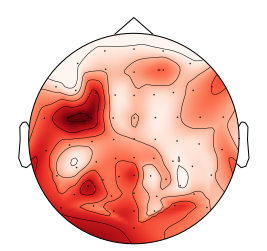

(<matplotlib.image.AxesImage at 0x831560da0>,
 <matplotlib.contour.QuadContourSet at 0x831571198>)

In [3]:
# features for perception map
%run EEG_auxiliary_module.ipynb
X, Y = convert_epochs_to_2D_array(epochs_perc[[str(x) for x in range(101,126)]], times=(0.05,0.65))
#X, Y = convert_epochs_to_2D_array(epochs_perc, times=(0.05,0.65))
coef, duration = run_svm_coef(X,Y)
%matplotlib inline
coefs=np.mean(np.abs(np.array(coef)),0)
fig, (ax1, ax2) = plt.subplots(1, 2)
mne.viz.plot_topomap(coefs,epochs_perc.info,vmin=np.min(coefs))


In [5]:
import itertools
len(list(itertools.combinations(np.unique(np.arange(1,101)), 2)))

4950

In [6]:
4950/60

82.5